# A code walk-through for the "Denoising Diffusion Probabilistic Models" paper

By [Tanishq Abraham](https://tmabraham.github.io)

This is a simple walk-through of the seminal 2020 paper [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) (DDPM). It was originally created for the [EleutherAI Diffusion Reading Group](github.com/tmabraham/diffusion_reading_group).

In this notebook, we'll go through the sections of the DDPM paper, diving into the math and examining how it corresponds to code. Let's get started!

We'll start with a few preliminaries like downloading a test image of a puppy and also getting our imports!

In [1]:
!wget https://images.newscientist.com/wp-content/uploads/2021/06/03141753/03-june_puppies.jpg?crop=1:1,smart&width=1200&height=1200&upscale=true
!mv "03-june_puppies.jpg?crop=1:1,smart" puppy.jpg

mv: cannot stat '03-june_puppies.jpg?crop=1:1,smart': No such file or directory


In [2]:
!pip install datasets > /dev/null
!pip install einops > /dev/null

In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, einsum
from torchvision import transforms
from datasets import load_dataset
from functools import partial
from einops import rearrange
from tqdm.notebook import *

# Background
Diffusion models are comprised of a forward diffusion process and a reverse diffusion process. The forward diffusion process takes an intact image and repeatedly adds noise until the image looks like pure noise. The reverse process starts with random noise and repeatedly applies a denoiser (which is a neural network we train) to eventually obtain/generate an intact image.

Let's start with defining some variables. Please pay attention to them, because they can admittedly get a little confusing.

$\mathbf{x}_{0}$ - the original image, before the destructive, noise-adding process

$\mathbf{x}_{T}$ - the final Gaussian noise, after the noise-adding process

The forward diffusion process is where we start out with a regular image $\mathbf{x}_{0}$ and gradually transition to Gaussian noise $\mathbf{x}_{T}$. The reverse difusion process starts out with $\mathbf{x}_{T}$ and "denoises" to the original image $\mathbf{x}_{0}$. 

Since diffusion models are composed of forward and reverse diffusion processes being repeatedly applied, there will be intermediate latent variables, $\mathbf{x}_{1},\mathbf{x}_{2}, \mathbf{x}_{i}, \dots, \mathbf{x}_{T-1}$. 

Remember, we want to estimate $p(\mathbf{x}_{0})$, the distribution of our dataset, so that we can sample from it. But the distribution is conditional on those latent variables (a _latent variable model_) , we must sum out (or marginalize out) the latent variables to get the marginal likelihood function:

$$p(\mathbf{x_0}) = ∫p(\mathbf{x_0}|\mathbf{x_{1:T}})\mathrm{d}\mathbf{x_{1:T}}\$$

So the question is how do we get $p(\mathbf{x_0}|\mathbf{x_{1:T}})$? We use the forward and reverse diffusion processes. 

These forward and reverse diffusion processes are stochastic processes technically known as [Markov chains](https://en.wikipedia.org/wiki/Markov_chain). A Markov chain is a "memoryless" stochastic process.  Looking at our forward process, it means that the probability distribution for $\mathbf{x}_{t}$ is only conditional on $\mathbf{x}_{t-1}$. 

$$\quad q\left(\mathbf{x}_{t} \mid \mathbf{x}_{t-1}\right):=\mathcal{N}\left(\mathbf{x}_{t} ; \sqrt{1-\beta_{t}} \mathbf{x}_{t-1}, \beta_{t} \mathbf{I}\right)$$

Here, $\mathcal{N}(\mathbf{x} ; \mathbf{\mu}, \mathbf{\sigma^2})\$ is the normal distribution parameterized by the mean and variance. 

So for our forward diffusion process, our variance is $\beta_{t}$ which is a variance taken from a pre-defined schedule. It increases over time. The mean is dependent on $\mathbf{x}_{t-1}$. Once again, just highlighting that this normal distribution is parameterized simply by the previous step, $\mathbf{x}_{t-1}$ (also $\beta_{t}$ but that's basically a custom constant), which is what makes a Markov chain. 

To actually calculate out the Markov chain, we simply sample from this distribution for each step. Let's see that in code:

In [4]:
img = torch.Tensor(np.array(Image.open('puppy.jpg'))) # open image
img /= 255.
n_steps=100 # how many steps to take in this stochastic forward diffusion process
num_imgs_to_show = 5 # how many images to display
every_n_imgs = int(n_steps // (num_imgs_to_show-1)) # calculate to save image every n steps

In [5]:
beta_min, beta_max = 0.0001, 0.02
beta = torch.linspace(beta_min, beta_max, n_steps) # get variances $beta_t$ 
def full_forward_process(x_0, every_n_imgs): # actual forward process stepping
    x_t_prev = x_0
    img_to_plot = [img] # list of images to show

    for t in range(n_steps): # perform forward process for n_steps
        mean = (1-beta[t])*x_t_prev # calculate the mean
        var = beta[t] # get the variance from the variance schedule
        x_t = np.random.normal(mean, var**0.5, size=x_t_prev.shape) # get $q(x_{t} | x_{t-1})$
        if (t+1) % every_n_imgs == 0: # if it's time to save
            img_to_plot.append(np.clip(x_t,a_min=0,a_max=1) ) # save to list
        x_t_prev = x_t
    return img_to_plot

In [6]:
img_to_plot = full_forward_process(img, every_n_imgs)

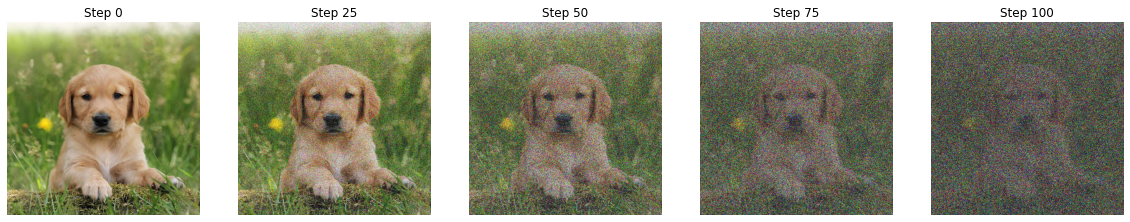

In [7]:
f, axarr = plt.subplots(1,len(img_to_plot),figsize=(20,20)) # create subplots
for i in range(len(img_to_plot)):
    axarr[i].imshow(img_to_plot[i]) # show img
    axarr[i].set_axis_off()
    axarr[i].set_title(f'Step {every_n_imgs*i}')

As you can see, this forward diffusion Markov process is actually quite simple in code. 

I'll note that as a Markov chain, since the probability distributions are only dependent on the previous step and therefore independent from each other, the following holds true:

$$q\left(\mathbf{x}_{1: T} \mid \mathbf{x}_{0}\right):=\prod_{t=1}^{T} q\left(\mathbf{x}_{t} \mid \mathbf{x}_{t-1}\right)$$

What this means is that for a given timestep $T$, we can get the probability distribution by multiplying the probability distributions for all the previous timestep $t=1,2,\dots,T$ since those probability distributions are independent. But if we set the variances to fixed constants, and since the product of two Gaussian distributions is also a Gaussian distribution, you can actually sample $\mathbf{x}_t$ at an arbitrary timestep $t$ as such.

$$ q(\mathbf{x}_t | \mathbf{x}_0 ) = \mathcal{N}(\mathbf{x}_t; \sqrt{\overline{\alpha}_t}\mathbf{x}_0, (1-\overline{\alpha}_t)\mathbf{I})$$

where $\overline{\alpha}_t = \prod^T_{i=1} \alpha_i$ and $\alpha_t = 1 - \beta_t$. 

Let's write a function that gives the sample from the forward process at any random timestep:

In [8]:
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)

def get_x_t(x_0, t):
    "given an image x_0 and timestep t, add noise to get x_t"
    alpha_bar_t = alpha_bar[t]
    mean = torch.sqrt(alpha_bar_t)*x_0
    var = 1-alpha_bar_t
    x_t = np.random.normal(mean, var**0.5, size=x_0.shape)
    return x_t

In [9]:
def full_forward_process(x_0, every_n_imgs): # actual forward process stepping
    x_t_prev = x_0
    img_to_plot = [img] # list of images to show

    for t in range(n_steps): # perform forward process for n_steps
        x_t = get_x_t(x_0, t)
        if (t+1) % every_n_imgs == 0: # if it's time to save
            img_to_plot.append(np.clip(x_t,a_min=0,a_max=1) ) # save to list
        x_t_prev = x_t
    return img_to_plot

In [10]:
img_to_plot = full_forward_process(img, every_n_imgs)

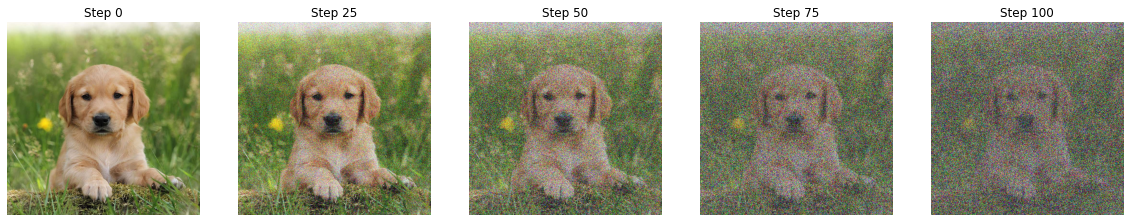

In [11]:
f, axarr = plt.subplots(1,len(img_to_plot),figsize=(20,20)) # create subplots
for i in range(len(img_to_plot)):
    axarr[i].imshow(img_to_plot[i]) # show img
    axarr[i].set_axis_off()
    axarr[i].set_title(f'Step {every_n_imgs*i}')

Okay, now let's look at the reverse diffusion process which goes from Gaussian noise $\mathbf{x}_{T}$ to an actual image $\mathbf{x}_{0}$. It is also a Markov chain, which means that obtaining $\mathbf{x}_{t-1}$ only needs $\mathbf{x}_{t}$. The reverse diffusion process is defined as follows:

$$ p_{\theta}\left(\mathbf{x}_{t-1} \mid \mathbf{x}_{t}\right):=\mathcal{N}\left(\mathbf{x}_{t-1} ; \boldsymbol{\mu}_{\theta}\left(\mathbf{x}_{t}, t\right), \mathbf{\Sigma}_{\theta}\left(\mathbf{x}_{t}, t\right)\right) $$

Now here we see that the mean and variance for our distribution is actually defined by two _functions_ $\boldsymbol{\mu}_{\theta}\left(\mathbf{x}_{t}, t\right), \mathbf{\Sigma}_{\theta}\left(\mathbf{x}_{t}, t\right)$ that depend on $\mathbf{x}_{t}$ and the current time step $t$. 

Now here's the key part: training a diffusion model is all about **learning** these mean and variance functions for the reverse diffusion process. In fact, $\boldsymbol{\mu}_{\theta}\left(\mathbf{x}_{t}, t\right)$ and $\mathbf{\Sigma}_{\theta}\left(\mathbf{x}_{t}, t\right)$ are actually **neural networks** parameterized by weights $θ \in Θ$.

You can imagine that once we train our model, the actual image synthesis process takes place in a manner similar to the data-destroying forward diffusion procces, since it is also a Markov chain:

In [12]:
def reverse_process(mean_func, var_func, img_size, n_steps):
    img = np.random.normal(shape=(img_size,img_size,3)) #get x_T$, our random noise starting point
    for i in range(n_steps):
        mean = mean_func(img,i) # calculate the mean using some neural network
        var = var_func(img,i) # calculate the variance, also potentially with a neural network
        noise = np.random.normal(size=img.shape) # standard normal distribution
        img = mean + (var**0.5)*noise # shift and scale standard normal distribution to get the desired $p(x_{t-1} | x_{t})$
    return img # return the generated image

Once again, being a Markov chain, the following holds true:

$$p_{\theta}\left(\mathbf{x}_{0: T}\right):=p\left(\mathbf{x}_{T}\right) \prod_{t=1}^{T} p_{\theta}\left(\mathbf{x}_{t-1} \mid \mathbf{x}_{t}\right)$$


We can summarize all of this with the following diagram:

![](https://www.assemblyai.com/blog/content/images/size/w1000/2022/05/image-1.png)
(taken from the DDPM paper)


Okay now we need to understand **how do we find the mean and variance functions of the reverse diffusion process?** Since we define these functions to be  parameterized by a neural network, what we are really asking is what loss function do we need to train these neural networks?

Well obviously, we want functions that maximize the likelihood of the training data:

$$\theta^{\star}=\arg \max _{\theta \in \Theta} p_{\theta}\left(\mathbf{x}_{0: T}\right)$$

So that means we have the following loss function:

$$ \mathcal{L}=\mathbb{E}_{\mathbf{x}_{0} \sim p_{\text {data }}}\left[-\log p_{\theta}\left(\mathbf{x}_{0}\right)\right] $$

Unfortunately, as we discussed, $p_{\theta}\left(\mathbf{x}_{0}\right) = ∫p_{\theta}(\mathbf{x_0}|\mathbf{x_{1:T}})\mathrm{d}\mathbf{x_{1:T}}$ is not [tractable](https://stats.stackexchange.com/questions/4417/what-are-the-factors-that-cause-the-posterior-distributions-to-be-intractable) so we need to find a way to approximate this loss.

The typical approach to do this in probabilistic inference is to use the Evidence Lower BOund (ELBO):

$$ \mathbb{E}_{\mathbf{x}_{0} \sim p_{\text {data }}}\left[-\log p_{\theta}\left(\mathbf{x}_{0}\right)\right] ≤ \mathbb{E}_{q \left (\mathbf{x_{0:T}} \right)} 
\left[ - \log \frac{q(\mathbf{x_{1:T}}|\mathbf{x_0})}{p_{\theta}(\mathbf{x_{0:T}} )} \right] =: \mathcal{L}_{ELBO}$$

The derivation for this is in the appendix.

Through some more mathematical manipulation, the loss function is rewritten as a series of Kullback-Liebler (KL) Divergence terms. This will make the loss function more tractable. If you are not familar with KL Divergences, it is basically a comparison between two probability distributions, and if the distributions are the same, the KL Divergence will be 0. The loss function now becomes:

$$ \mathcal{L}_{ELBO} = \mathbb{E}_{q}[\underbrace{D_{\mathrm{KL}}\left(q\left(\mathbf{x}_{T} \mid \mathbf{x}_{0}\right) \| p\left(\mathbf{x}_{T}\right)\right)}_{L_{T}}+\sum_{t>1} \underbrace{D_{\mathrm{KL}}\left(q\left(\mathbf{x}_{t-1} \mid \mathbf{x}_{t}, \mathbf{x}_{0}\right) \| p_{\theta}\left(\mathbf{x}_{t-1} \mid \mathbf{x}_{t}\right)\right)}_{L_{t-1}} \underbrace{-\log p_{\theta}\left(\mathbf{x}_{0} \mid \mathbf{x}_{1}\right)}_{L_{0}}] $$

where $D_{\mathrm{KL}} \left(A \| B \right)$ is the KL Divergence between distributions $A$ and $B$. Since the KL Divergences are being calculated between Gaussian distributions, the loss function is now tractable, since it can be analytically calculated with a [closed-form expression](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Multivariate_normal_distributions).

Note that $q\left(\mathbf{x}_{t-1} \mid \mathbf{x}_{t}, \mathbf{x}_{0}\right)$ is defined as:


$$ q(\mathbf{x}_{t-1} | \mathbf{x}_t,\mathbf{x}_0) = \mathcal{N}(\mathbf{x}_{t-1}; \tilde{\mu}_t(\mathbf{x}_t, \mathbf{x}_0), \tilde{\beta}_t \mathbf{I}) $$

where:

 $$\tilde{\mu}_t(\mathbf{x}_t, \mathbf{x}_0) := \frac{\sqrt{\overline{\alpha}_{t-1}}\beta_t}{1-\overline{\alpha}_t}\mathbf{x}_0 + \frac{\sqrt{\overline{\alpha}_t}(1-\overline{\alpha}_{t-1})}{1-\overline{\alpha}_t}\mathbf{x}_t , \tilde{\beta}_t := \frac{1-\overline{\alpha}_{t-1}}{1-\overline{\alpha}_{t}}\beta_t $$

$L_0$ is a standard reconstruction term (like the one seen for variational autoencoders). $L_T$, as a KL divergence term, basically just lets us know how close the forward process $q\left(\mathbf{x}_{T} \mid \mathbf{x}_{0}\right)$ is with the Gaussian prior $p\left(\mathbf{x}_{T}\right)$. And $L_{t-1}$, also a KL divergence term, allows us to match the distribution of $\mathbf{x}_{t-1}$ that we get from our learned reverse process, $p_{\theta}\left(\mathbf{x}_{t-1} \mid \mathbf{x}_{t}\right)$, to the actual distribution of $x_{t-1}$ produced by the forward process, $q\left(\mathbf{x}_{t-1} \mid \mathbf{x}_{t}, \mathbf{x}_{0}\right)$. 

# Diffusion models and denoising autoencoders

DDPM makes several choices to further simplify the model and loss function.

Once again, this is our model (reverse process):
$$ p_{\theta}\left(\mathbf{x}_{t-1} \mid \mathbf{x}_{t}\right):=\mathcal{N}\left(\mathbf{x}_{t-1} ; \boldsymbol{\mu}_{\theta}\left(\mathbf{x}_{t}, t\right), \mathbf{\Sigma}_{\theta}\left(\mathbf{x}_{t}, t\right)\right) $$

One assumption that is made is to set the variance $\mathbf{\Sigma}_{\theta}\left(\mathbf{x}_{t}, t\right)= σ^2_t \mathbf{I}$. That is, the variance is actually a constant. We can set $σ^2_t = \beta_t$.

Now with this assumption we can simplify the loss function further.
Let's look at $L_T$:

$$ L_T = \mathbb{E}_{q}[D_{\mathrm{KL}}\left(q\left(\mathbf{x}_{T} \mid \mathbf{x}_{0}\right) \| p\left(\mathbf{x}_{T}\right)\right)]$$

Since $p\left(\mathbf{x}_{T}\right)$ is just a normal distribution and $q\left(\mathbf{x}_{T} \mid \mathbf{x}_{0}\right)$ has not learnable parameters as we assumed $\beta_t$ is constant, this entire loss term is constant. So for the purposes of optimization, we can ignore it.


Now let's simplify $L_{t-1}$. Based on the equation for the KL divergence [between two Gaussians](https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians):

$$ L_{t-1} = D_{\mathrm{KL}}\left(q\left(\mathbf{x}_{t-1} \mid \mathbf{x}_{t}, \mathbf{x}_{0}\right) \| p_{\theta}\left(\mathbf{x}_{t-1} \mid \mathbf{x}_{t}\right)\right) = \mathbb{E}_q \left [\frac{1}{2σ^2_t} \| \tilde{μ_t}\left(\mathbf{x}_t,\mathbf{x}_0 \right) - μ_θ\left(\mathbf{x}_t,t \right) \|^2 \right] + C $$

For $σ^2_t = \beta_t$, that constant will turn out to be $\frac{\overline{\alpha}_t-\overline{\alpha}_{t-1}}{2(1-\overline{\alpha_t})}$, but obviously, being a fixed constant in the loss functions, it can be ignored for optimization/training purposes.

Let's take a _quick_ step back and understand what this means. This is just an mean squared error (MSE) reconstruction loss between the reverse process posterior mean and the forward process posterior mean. So the most simple parameterization of $\mu_\theta$ simply predicts the diffusion posterior mean. This is in fact a valid apporach, but the authors found training like this to be unstable. So we will _reparameterize_ again:

Next, let's reparametrize $\mathbf{x}_t(\mathbf{x}_0,\epsilon) = \sqrt{\overline{\alpha}_t}\mathbf{x}_0 + \sqrt{1-\overline{\alpha}_t}\epsilon$ where $\epsilon$ is just a random vector sampled from the unit normal distribution $\epsilon \sim \mathcal{N}(\mathbf{0},\mathbf{I}) $. (This really is just another way of describing the forward process and writing down $q(\mathbf{x}_t|\mathbf{x}_0)$). Plugging in this reparameterization as well as the definition of $\tilde{μ_t}\left(\mathbf{x}_t,\mathbf{x}_0 \right)$ into the loss function gives:

$$ L_{t-1} - C = \mathbb{E}_{\mathbf{x}_{0}, \boldsymbol{\epsilon}}\left[\frac{1}{2 \sigma_{t}^{2}}\left\|\frac{1}{\sqrt{\alpha_{t}}}\left(\mathbf{x}_{t}\left(\mathbf{x}_{0}, \boldsymbol{\epsilon}\right)-\frac{\beta_{t}}{\sqrt{1-\bar{\alpha}_{t}}} \boldsymbol{\epsilon}\right)-\boldsymbol{\mu}_{\theta}\left(\mathbf{x}_{t}\left(\mathbf{x}_{0}, \boldsymbol{\epsilon}\right), t\right)\right\|^{2}\right] $$

The important trick of DDPM however is realizing $\mathbf{x}_{t}$ is the input of the model and therefore doing _one final reparameterization_ of introducing a learned function $\boldsymbol{\epsilon}_\theta (\mathbf{x}_t,t)$ that estimates $\epsilon$. 

This simplifies the loss function to:

$$ \mathbb{E}_{\mathbf{x}_{0}, \boldsymbol{\epsilon}}\left[\frac{\beta_{t}^{2}}{2 \sigma_{t}^{2} \alpha_{t}\left(1-\bar{\alpha}_{t}\right)}\left\|\boldsymbol{\epsilon}-\boldsymbol{\epsilon}_{\theta}\left(\sqrt{\bar{\alpha}_{t}} \mathbf{x}_{0}+\sqrt{1-\bar{\alpha}_{t}} \boldsymbol{\epsilon}, t\right)\right\|^{2}\right] $$

Again, this is another time to take a quick step back and think again what this means. It's helpful when thinking about diffusion models about the data manifold/distribution. 

Remember, we have our forward process to get $\mathbf{x}_t$, which we can do with $\mathbf{x}_t(\mathbf{x}_0,\epsilon) = \sqrt{\overline{\alpha}_t}\mathbf{x}_0 + \sqrt{1-\overline{\alpha}_t}\epsilon$. You can see that we start out in the data manifold and we perturb it off the data manifold. Now, when we say "predicting the noise" we mean the "noise" that took an image away from the data distribution and closer to random noise, and then we reverse that, as in we go towards the data distribution.

Alternatively, it may make sense to realize that if we want to denoise a image, we need to remove that noise to the best of our ability, so we instead try to predict the noisy component so we can remove it from the image. In fact, you can see from the loss function that we perform a linear combination of the original image and noise (which is itself $\mathbf{x}_t$), pass it into our "noise-predicting" function.

Finally, $L_0$ can technically be calculated by using the cumulative distribution function (CDF) to get probabilities for discrete pixel values and calculate the log-likelihood, but in practice it is ignored and the final image is also just $μ_θ\left(\mathbf{x}_1,1 \right)$ without any noise.

## Simplified training objective

While the above MSE loss works fine, the authors found it ound it beneficial to sample quality (and simpler to implement) to train on the following variant of the objective:

$$ L_{\text{simple}}(\theta) := \mathbb{E}_{t, \mathbf{x}_{0}, \boldsymbol{\epsilon}} \left[\left\|\boldsymbol{\epsilon}-\boldsymbol{\epsilon}_{\theta}\left(\sqrt{\bar{\alpha}_{t}} \mathbf{x}_{0}+\sqrt{1-\bar{\alpha}_{t}} \boldsymbol{\epsilon}, t\right)\right\|^{2}\right] $$

where $t$ is uniform between $1$ and $T$. 

Let's code this up!

In [13]:
n_steps = 1000
beta = torch.linspace(0.0001, 0.02, n_steps) # get variances $beta_t$ 
alpha = 1-beta
alpha_bar = torch.cumprod(alpha, dim=0)
    
def get_x_t(x_0,t,eps):
    alpha_bar_t = alpha_bar[t].reshape(-1, 1, 1, 1).to(x_0.device) # reshaping to get it to work for batches, put on right device
    x_t = torch.sqrt(alpha_bar_t)*x_0 + torch.sqrt(1-alpha_bar_t)*eps # rewritten with the reparameterization
    return x_t

def loss(x_0, t, eps_theta):
    eps = torch.randn_like(x_0)
    x_t = get_x_t(x_0,t,eps)
    return F.mse_loss(eps, eps_theta(x_t,t)) # simple MSE losss

As you can see, we need to define `eps_theta`, which is our neural network! This neural network needs to take in an image $\mathbf{x}_t$, a timestep $t$, and output another image of the same shape $\boldsymbol{\epsilon}$, the predicted noise. We use a U-net architecture slightly modified to be conditioned on the timestep. The timestep information is injected into the neural network using sinusoidal embeddings, similar to how position information is injected into Transformers. 


Let's code up the U-net. We'll start out with some helper functions:

In [14]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

You can see we'll use standard residual layers, downsampling is performed with convolutions and upsampling is performed with standard nearest-neighbor upsampling followed by a convolutional layer.

Let's look at the sinusoidal position embedding now:

In [15]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

Next let's define our residual blocks:

In [16]:
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""
    
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)
    
class ConvNextBlock(nn.Module):
    """https://arxiv.org/abs/2201.03545"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if exists(self.mlp) and exists(time_emb):
            assert exists(time_emb), "time embedding must be passed in"
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)

Pretty standard ResNet Block (conv-norm-activation combination + residual connection), with the exception of the time embedding which is passed into an MLP and then added to the output of the block before being passed into the block.

Next, DDPM uses attention in between the convolutional blocks:

In [17]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

We have a simple module to have the normalization before the attention:

In [18]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

With these modules and helper functions, we can put together the full U-net.

The  network takes a batch of noisy images $\mathbf{x}_t$ of shape (batch_size, num_channels, height, width) and a batch of timesteps $t$ of shape (batch_size, 1) as input, and returns a predicted noise added $\boldsymbol{\epsilon}$ of shape (batch_size, num_channels, height, width).

In [19]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        
        if use_convnext:
            block_klass = partial(ConvNextBlock, mult=convnext_mult)
        else:
            block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)

Okay with our defined U-net let's train a model!

# Experiments

The original paper experimented with CIFAR-10 and LSUN datasets but here we will try training a model on Fashion MNIST.

In [20]:
# load dataset from the hub
dataset = load_dataset("fashion_mnist")
image_size = 32
channels = 1
batch_size = 128


Found cached dataset fashion_mnist (/home/tmabraham/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)


  0%|          | 0/2 [00:00<?, ?it/s]

Let's set up our PyTorch DataLoaders. To make life simpler with the dimensions for the model, let's resize to 32x32. Note that we need to rescale the data to be in between $[-1, 1]$. Also, we will use a horizontal flip transformation, which was used in the original paper as well.

In [21]:
# define image transformations
transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.RandomHorizontalFlip(), # augmentation used for DDPM
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1) # Rescale between -1 and 1
])

# define function
def img_transforms(examples):
   examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
   del examples["image"]
   return examples

transformed_dataset = dataset.with_transform(img_transforms).remove_columns("label") # apply the transformations
dataloader = torch.utils.data.DataLoader(transformed_dataset["train"], batch_size=batch_size, shuffle=True) # create dataloader

Now let's initialize our model and optimizer:

In [22]:
device = "cuda:2" if torch.cuda.is_available() else "cpu"
model = Unet(dim=image_size, channels=channels, dim_mults=(1, 2, 4,))
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Finally, let's set up our training loop:

In [23]:
epochs = 5
for epoch in range(epochs):
    for step, batch in enumerate(tqdm(dataloader)):
        x_0 = batch["pixel_values"].to(device)
        batch_size = x_0.shape[0]
        t = torch.randint(0, n_steps, (batch_size,), device=device).long() #randomly sample t in a uniform manner for every example in the batch
        loss_val = loss(x_0, t, model)
        if step % 100 == 0: print("Loss:", loss_val.item())
        loss_val.backward()
        optimizer.step()
        optimizer.zero_grad()

  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 1.154261589050293
Loss: 0.16096770763397217
Loss: 0.07137969136238098
Loss: 0.055716026574373245
Loss: 0.05317643657326698


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.03907962888479233
Loss: 0.04893118143081665
Loss: 0.06425464153289795
Loss: 0.033566467463970184
Loss: 0.04291877895593643


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.04395158588886261
Loss: 0.057903047651052475
Loss: 0.041225284337997437
Loss: 0.06641087681055069
Loss: 0.049482449889183044


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.03580917418003082
Loss: 0.0366058275103569
Loss: 0.04055546224117279
Loss: 0.045933276414871216
Loss: 0.03170652687549591


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.038605690002441406
Loss: 0.03754499554634094
Loss: 0.0299801304936409
Loss: 0.04720523953437805
Loss: 0.03862304985523224


## Sampling loop

The following is the sampling loop:
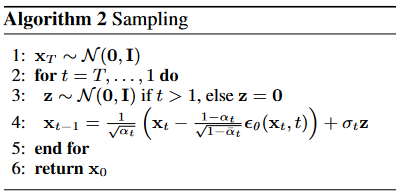

This can be derived by predicting the original image by subtracting the predicted noise:

$$ \mathbf{x}_0 \approx \hat{\mathbf{x}}_0 = (\mathbf{x}_t - \sqrt{1-\bar{\alpha}_t} \boldsymbol{\epsilon}(\mathbf{x}_t,t))/\sqrt{\bar{\alpha}_t} $$

which is then plugged into the formula for $q\left(\mathbf{x}_{t-1} \mid \mathbf{x}_{t}, \mathbf{x}_{0}\right)$ and $\mathbf{x}_{t-1}$ is sampled from this.

Let's code it up!

In [24]:
sigma = torch.sqrt(beta)
alphas_cumprod_prev = F.pad(alpha_bar[:-1], (1, 0), value=1.0)
posterior_variance = beta * (1. - alphas_cumprod_prev) / (1. - alpha_bar)

@torch.no_grad()
def sample(eps_theta, image_size, batch_size=16, channels=3):
    shape = (batch_size, channels, image_size, image_size)
    x_T = torch.randn(shape, device=device)
    x_t = x_T
    for t in tqdm(reversed(range(n_steps)),total=n_steps):
        t_batch = torch.full((x_t.shape[0],), t, device=x_t.device, dtype=torch.long)
        z = torch.randn(x_t.shape, device=x_t.device) if t > 0 else torch.zeros(x_t.shape, device=x_t.device)
        alpha_t = alpha[t] # get noise level at current timestep
        alpha_bar_t = alpha_bar[t]
        sigma_t = sigma[t] #torch.sqrt(posterior_variance[t])
        x_t = (1.0/torch.sqrt(alpha_t)) * (x_t - (1-alpha_t)/torch.sqrt(1-alpha_bar_t) * eps_theta(x_t, t_batch))  + sigma_t*z # predict x_(t-1)
    x_0 = x_t
    return x_0

In [25]:
x_0 = sample(model, 32, 64, channels=1)

  0%|          | 0/1000 [00:00<?, ?it/s]

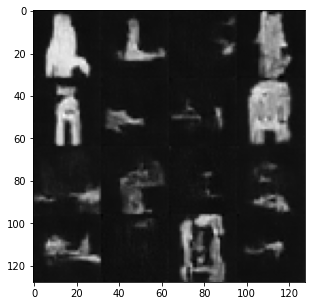

In [26]:
# without linear attention
plt.figure(figsize=(5,5))
plt.imshow(torchvision.utils.make_grid(x_0[:16], nrow=4,padding=0)[0].cpu(), cmap="gray")

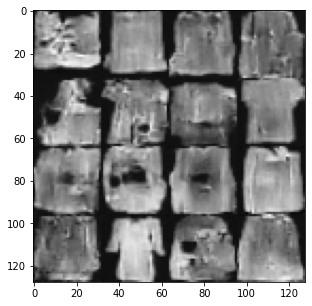

In [27]:
# without linear attention
plt.figure(figsize=(5,5))
plt.imshow(torchvision.utils.make_grid(x_0[:16], nrow=4,padding=0)[0].cpu(), cmap="gray")

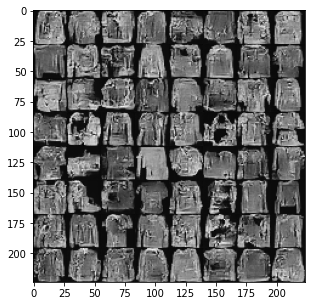

In [ ]:
# without linear attention
plt.figure(figsize=(5,5))
plt.imshow(torchvision.utils.make_grid(x_0, nrow=8,padding=0)[0].cpu(), cmap="gray")

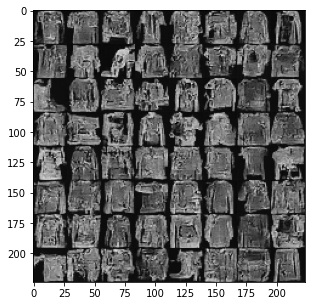

In [ ]:
# without linear attention
plt.figure(figsize=(5,5))
plt.imshow(torchvision.utils.make_grid(x_0, nrow=8,padding=0)[0].cpu(), cmap="gray")

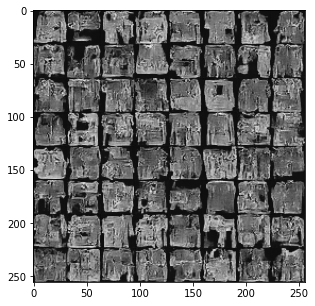

In [ ]:
# without linear attention
plt.figure(figsize=(5,5))
plt.imshow(torchvision.utils.make_grid(x_0, nrow=8,padding=0)[0].cpu(), cmap="gray")

These look like some decent fashion MNIST images!